# ПРАКТИКА ML-7. Оптимизация гиперпараметров модели

## Описание задачи

Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  Каждая строка представляет молекулу.

Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1];
Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Необходимо обучить две модели: логистическую регрессию и случайный лес. Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [37]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

#plt.style.use('seaborn')

random_state = 42

CPU = -1

### Загрузка и исследование данных

In [38]:
data = pd.read_csv('C:\скил\DST-156\IDE_NEW\ML-7. Оптимизация гиперпараметров модели/_train_sem09__1_.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# Проверяем наличие пропусков

data.isnull().sum().value_counts()

0    1777
Name: count, dtype: int64

In [40]:
# типы данных

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


In [41]:
# сбалансированность классов
data['Activity'].value_counts(True)

Activity
1    0.542255
0    0.457745
Name: proportion, dtype: float64

<Axes: xlabel='Activity', ylabel='count'>

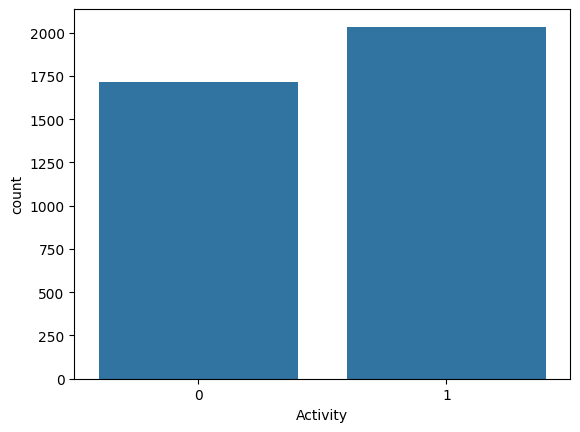

In [42]:
sns.countplot(data=data, x='Activity') # визуализируем сбалансированность классов

Дисбаланс классов небольшой. Но стратификацию всё равно лучше оставить.

In [43]:
# матрица наблюдений - X
# вектор ответов - y

X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [44]:
# Разделяем выборку на тренировочную и тестовую в соотношении 80/20.
# Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение).

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=random_state, test_size=0.2)

## 1. LogisticRegression 

Получим метрики, без дополнительной настройки, со значениями гиперпараметров, установленных по умолчанию.

In [56]:
# объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(random_state=random_state)

# обучаем модель, минимизируя logloss
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
# выводим значения метрики на тестовой выборке
print(f'f1_score на тестовом наборе LogisticRegression с параметрами по умолчанию : {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе LogisticRegression с параметрами по умолчанию : 0.780


### Оптимизация гиперпараметров модели

#### 1.1. GridSearchCV

In [76]:
# сетка гиперпараметров в виде списка словарей
param_grid_lr = [
    {
        'penalty': ['l2', 'none'],  # тип регуляризации
        'solver': ['lbfgs', 'sag'],  # алгоритм оптимизации
        'C': list(np.linspace(0.01, 1, 10, dtype=float))  # уровень силы регурялизации
    },
    {
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'C': list(np.linspace(0.01, 1, 10, dtype=float))
    }
]

# объект класса GridSearch
grid_search_lr = GridSearchCV(
        estimator=linear_model.LogisticRegression(
        random_state=random_state,
        max_iter=50  # количество итераций на сходимость
    ),
    param_grid=param_grid_lr,
    cv=5,  #количество фолдов кросс-валидации
    n_jobs=CPU
)

%time grid_search_lr.fit(X_train, y_train)

y_test_pred_lr_gs = grid_search_lr.predict(X_test)
print(f'f1_score на тестовом наборе LogisticRegression оптимизация параметров GridSearchCV: {metrics.f1_score(y_test, y_test_pred_lr_gs) :.3f}')
print(f'Наилучшие значения гиперпараметров: {grid_search_lr.best_params_}')

CPU times: total: 4.62 s
Wall time: 1min 50s
f1_score на тестовом наборе LogisticRegression оптимизация параметров GridSearchCV: 0.783
Наилучшие значения гиперпараметров: {'C': 0.34, 'penalty': 'l1', 'solver': 'saga'}


Метрику удалось улучшить незначительно по сравнению с параметрами, заданными по-умолчанию.

#### 1.2. RandomizedSearchCV

In [47]:
# сетка гиперпараметров в виде списка словарей
param_distributions_lr_rs = [
    {
        'penalty': ['l2', 'none'],  # тип регуляризации
        'solver': ['lbfgs', 'sag'],  # алгоритм оптимизации
        'C': list(np.linspace(0.01, 1, 10, dtype=float))  # уровень силы регурялизации
    },
    {
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'C': list(np.linspace(0.01, 1, 10, dtype=float))
    }
]

# объект класса RandomizedSearch
random_search = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=random_state, max_iter=50),
    param_distributions=param_distributions_lr_rs,
    cv=5,  # количество фолдов кросс-валидации
    n_iter=20,  # количество итераций
    n_jobs=CPU
)

%time random_search.fit(X_train, y_train)

y_test_pred_lr_rs = random_search.predict(X_test)
print(f'f1_score на тестовом наборе оптимизация параметров RandomizedSearchCV: {metrics.f1_score(y_test, y_test_pred_lr_rs) :.3f}')
print(f'Наилучшие значения гиперпараметров: {random_search.best_params_}')

CPU times: total: 2.86 s
Wall time: 25.3 s
f1_score на тестовом наборе оптимизация параметров RandomizedSearchCV: 0.783
Наилучшие значения гиперпараметров: {'solver': 'saga', 'penalty': 'l1', 'C': 0.34}


Метрика не изменилась по сравнению с GridSearch, но сработала значительно быстее. При этом методы предложили разные алгоритмы оптимизации.

#### 1.3. Hyperopt

In [48]:
def hyperopt_lr(
        params,
        cv=5,
        X=X_train,
        y=y_train,
        random_state=random_state
):
    params = {
        'penalty': params['penalty'],
        'solver': params['solver'],
        'C': params['C']
    }

    model = linear_model.LogisticRegression(
        **params,
        random_state=random_state,
        max_iter=50
    )

    model.fit(X, y)

    # применим  cross validation с количеством фолдов по-умолчанию
    score = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring='f1',
        n_jobs=CPU
    ).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [49]:
# пространство поиска гиперпараметров
space_lr = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'solver': hp.choice('solver', ['liblinear', 'saga']),
    'C': hp.uniform('C', 0.01, 1)
}

In [50]:
%%time

trials_lr = Trials() # используется для логирования результатов

best_lr = fmin(
    hyperopt_lr,
    space=space_lr,        # пространство гиперпараметров
    algo=tpe.suggest,   # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=20,       # максимальное количество итераций
    trials=trials_lr,      # логирование результатов
    rstate=np.random.default_rng(random_state)
)

print(f'Наилучшие значения гиперпараметров {best_lr}')

100%|██████████| 20/20 [01:14<00:00,  3.71s/trial, best loss: -0.7904516202991784]
Наилучшие значения гиперпараметров {'C': 0.2200949458234019, 'penalty': 0, 'solver': 1}
CPU times: total: 25.2 s
Wall time: 1min 14s


In [51]:
# точность для тестовой выборки
model_lr_ho = linear_model.LogisticRegression(
    random_state=random_state,
    penalty='l1',
    solver='saga',
    C=best_lr['C'],
    max_iter=50
)

model_lr_ho.fit(X_train, y_train)
y_test_pred_lr_ho = model.predict(X_test)
print(f'f1_score на тестовом наборе оптимизация параметров Hyperopt: {metrics.f1_score(y_test, y_test_pred_lr_ho) :.3f}')

f1_score на тестовом наборе оптимизация параметров Hyperopt: 0.784


Метрика увеличилась по сравнению с предыдущими значениями

#### 1.4. Optuna

In [52]:
def optuna_rf(trial):
    # пространство поиска гиперпараметров
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    C = trial.suggest_float('C', 0.01, 1)

    model = linear_model.LogisticRegression(
        penalty=penalty,
        solver=solver,
        C=C,
        max_iter=50,
        random_state=random_state
    )

    model.fit(X_train, y_train)

    # применим cross validation с тем же количеством фолдов
    score = cross_val_score(
        model,
        X,
        y,
        cv=5,
        scoring='f1',
        n_jobs=CPU
    ).mean()

    return score

In [53]:
%%time
# объект исследования
study = optuna.create_study(
    study_name='LogisticRegression',
    direction='maximize'
)

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# результаты на обучающей выборке
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'f1_score на обучающем наборе: {study.best_value :.3f}')

Наилучшие значения гиперпараметров {'penalty': 'l1', 'solver': 'saga', 'C': 0.23678000210646447}
f1_score на обучающем наборе: 0.789
CPU times: total: 26 s
Wall time: 1min 39s


In [54]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params, max_iter=50, random_state=random_state)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(f'f1_score на тестовом наборе LogisticRegression оптимизация параметров Optuna: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе LogisticRegression оптимизация параметров Optuna: 0.784


In [ ]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Метрика не изменилась в сравнениие с  Hyperopt

## 2.RandomForest

In [55]:
# объект класса случайный лес
rf = ensemble.RandomForestClassifier(random_state=random_state)

rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print(f'f1_score на тестовом наборе RandomForest с параметрами по умолчанию: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе RandomForest с параметрами по умолчанию: 0.805


Случайный лес сразу выдает результаты, лучше, чем у логистической регресии

### Оптимизация гиперпараметров модели

#### 2.1. GridSearchCV

In [77]:
param_grid_forest = [
              {'n_estimators': list(np.linspace(100, 500, 5, dtype=int)),
                'criterion': ['gini', 'entropy'],
               'max_depth': list(np.linspace(5, 30, 6, dtype=int)),
               'min_samples_leaf': list(np.linspace(1, 30, 5, dtype=int))}
             ]

grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),
    param_grid=param_grid_forest,
    cv=5,
    n_jobs=CPU
)

%time grid_search_forest.fit(X_train, y_train)

y_test_pred_rf_gs = grid_search_forest.predict(X_test)
print(f'f1_score на тестовом наборе RandomForest оптимизация параметров GridSearchCV: {metrics.f1_score(y_test, y_test_pred_rf_gs) :.3f}')
print(f'Наилучшие значения гиперпараметров: {grid_search_forest.best_params_}')

KeyboardInterrupt: 

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

#### 2.2. RandomizedSearchCV

In [65]:
param_distributions_rf = {'n_estimators': list(np.linspace(100, 500, 5, dtype=int)),
                'criterion': ['gini', 'entropy'],
               'max_depth': list(np.linspace(5, 30, 6, dtype=int)),
               'min_samples_leaf': list(np.linspace(1, 30, 5, dtype=int))}

random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=random_state),
    param_distributions=param_distributions_rf,
    cv=5,
    n_iter=30,
    n_jobs=CPU
)

%time random_search_forest.fit(X_train, y_train)

y_test_pred_rf_rs = random_search_forest.predict(X_test)
print(f'f1_score на тестовом наборе RandomForest оптимизация параметров RandomizedSearchCV: {metrics.f1_score(y_test, _rf_rs) :.3f}')
print(f'Наилучшие значения гиперпараметров: {random_search_forest.best_params_}')

CPU times: total: 3.31 s
Wall time: 1min 16s
f1_score на тестовом наборе RandomForest оптимизация параметров RandomizedSearchCV: 0.806
Наилучшие значения гиперпараметров: {'n_estimators': 200, 'min_samples_leaf': 1, 'max_depth': 15, 'criterion': 'gini'}


#### 2.3. Hyperopt

In [61]:
def hyperopt_rf(
        params,
        cv=5,
        X=X_train,
        y=y_train,
        random_state=random_state
):
    params = {
        'n_estimators': int(params['n_estimators']),
        'max_depth': int(params['max_depth']),
        'min_samples_leaf': int(params['min_samples_leaf'])
    }

    model = ensemble.RandomForestClassifier(**params, random_state=random_state)

    model.fit(X, y)

    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    return -score

In [63]:
criterion = ['gini', 'entropy']
space = {'n_estimators': hyperopt.hp.quniform('n_estimators', 100, 500, 10),
            'criterion': hyperopt.hp.choice('criterion', criterion),
            'max_depth': hyperopt.hp.quniform('max_depth', 5, 30, 1),
            'min_samples_leaf': hyperopt.hp.quniform('min_samples_leaf', 2, 30, 1)}

In [64]:
%%time

trials = Trials()

best = fmin(
    hyperopt_rf,
    space=space,        # пространство гиперпараметров
    algo=tpe.suggest,   # алгоритм оптимизации, установлен по умолчанию, задавать необязательно
    max_evals=30,       # максимальное количество итераций
    trials=trials,      # логирование результатов
    rstate=np.random.default_rng(random_state)
)

print(f'Наилучшие значения гиперпараметров {best}')

100%|██████████| 30/30 [03:02<00:00,  6.09s/trial, best loss: -0.8208340781946408]
Наилучшие значения гиперпараметров {'criterion': 1, 'max_depth': 15.0, 'min_samples_leaf': 2.0, 'n_estimators': 160.0}
CPU times: total: 1min 7s
Wall time: 3min 2s


In [66]:
model = ensemble.RandomForestClassifier(
    random_state=random_state,
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print(f'f1_score на тестовом наборе RandomForest оптимизация параметров Hyperopt: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе RandomForest оптимизация параметров Hyperopt: 0.802


#### 2.4. Optuna

In [67]:
def optuna_rf(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 30)

    model = ensemble.RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        random_state=random_state
    )
    model.fit(X_train, y_train)

    score = cross_val_score(
        model,
        X,
        y,
        cv=5,
        scoring='f1',
        n_jobs=CPU
    ).mean()

    return score

In [68]:
%%time
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=30)

print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'f1_score на обучающем наборе: {study.best_value :.3f}')

Наилучшие значения гиперпараметров {'criterion': 'entropy', 'n_estimators': 355, 'max_depth': 30, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.817
CPU times: total: 1min 17s
Wall time: 4min 42s


In [70]:
# точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train, y_train)

y_test_pred = model.predict(X_test)
print(f'f1_score на тестовом наборе RandomForest оптимизация параметров Optuna: {metrics.f1_score(y_test, y_test_pred) :.3f}')

f1_score на тестовом наборе RandomForest оптимизация параметров Optuna: 0.814
